<a href="https://colab.research.google.com/github/zcwisc/GB657/blob/main/Module_2_PredictingReturn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using Characteristics to Predict Stock Returns**

In this tutorial, we illustrate a real-world application of decision trees, random forests (bagging), and XGBoost (boosting). Specifically, we use these models to predict stock returns based on a high-dimensional set of firm and stock characteristics.

# Setup the work space

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
wd = '/content/gdrive/MyDrive/UW-Madison/GEN BUS 657/Module 2/Data/'

Mounted at /content/gdrive


## Load packages

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

## Load the data

The dataset was created by merging the stock-month characteristics from DACHENG XIU: https://dachxiu.chicagobooth.edu) and merging them with stock-month CRSP returns data. Important -- characteristics are already lagged by 1 month.

You can find the data here: https://drive.google.com/drive/folders/1lrPGnTBPN9_qk3_aVjQL0pqVVhBrTADL?usp=sharing

Please also follow the instruction (***[Colab Setup Step 3] Mounting Google Drive to Colab for Dataset Access***) on Canvas Module 0 to access the shared data.

In [3]:
merged_all = pd.read_pickle(wd+'Characteristics_Returns')

Prepare the data:
- add a column for market returns (you'll see soon why)
- drop observations with missing returns
- impute missing characteristics
- in this model we will add industry classification as an explanatory variable; notice that it effectively adds not one but 73 columns to the data

In [4]:
merged_all['Mkt'] = merged_all['Mkt-RF']+merged_all['RF']

merged_all['RET'] =  pd.to_numeric(merged_all['RET'],errors='coerce')
merged_all = merged_all.replace([np.inf, -np.inf], np.nan)
merged_all = merged_all.dropna(subset=['RET'])

cols = merged_all.columns[2:96]
for c in cols:
    merged_all[c] = merged_all[c].fillna(merged_all.groupby('DATE')[c].transform('mean'))

sic_dummies = pd.get_dummies(merged_all['sic2'],prefix='sic')

We'll start with the same train-test split but then implement a rolling estimation technique. Also, notice that we're merging in the SIC dummies dataset.

In [5]:
X_train = merged_all[merged_all['DATE']<'2007-01'].iloc[:,2:96]
X_train = pd.merge(X_train,sic_dummies,left_index=True,right_index=True,how='left')
X_test = merged_all[merged_all['DATE']>='2007-01'].iloc[:,2:96]
X_test = pd.merge(X_test,sic_dummies,left_index=True,right_index=True,how='left')
Y_train = merged_all[merged_all['DATE']<'2007-01']['RET'] - merged_all[merged_all['DATE']<'2007-01']['Mkt']
Y_test = merged_all[merged_all['DATE']>='2007-01']['RET'] - merged_all[merged_all['DATE']>='2007-01']['Mkt']

# Decision trees

Let's estimate two decision tree for the first 1,000 observations in the train data: one using a continuous dependent variable ("regression model") and another using a dummy for whether excess returns were positive or negative ("classification model").

Note that the only parameter that we feed the estimation procedure is the max depth of the tree.

In [6]:
dtr = tree.DecisionTreeRegressor(max_depth=3)
dtr = dtr.fit(X_train.iloc[0:1000,:],Y_train.iloc[0:1000])

In [7]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=1500)
tree.plot_tree(dtr,feature_names = X_test.columns, filled = True, proportion=True)
fig.savefig('decisiontree.png')

Now for classification, i.e., predicting positive/negative return:

In [8]:
dtc = tree.DecisionTreeClassifier(max_depth=3)
dtc = dtc.fit(X_train.iloc[0:1000,:],Y_train.iloc[0:1000]>0)

In [9]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=1500)
tree.plot_tree(dtc,feature_names = X_test.columns, filled = True, proportion=True)
fig.savefig('decisiontree_class.png')

The classification model outputs the predictions as "value = [xxx,yyy]". How would you check whether the value to the left corresponds to the positive or negative returns?

# From Predicted Returns to Trading Strategies

Once we have a model that predicts future stock returns (such as a Random Forest), we can transform these predictions into a simple trading strategy. A common approach is to sort stocks each month by their predicted returns and form long-short portfolios: going long (buying) the stocks with the highest predicted returns and short (selling) those with the lowest. This way, the portfolio's performance reflects the model's ability to distinguish future winners from losers, rather than its ability to predict exact return magnitudes.

To evaluate how well such a strategy performs, we often use the Sharpe ratio. The Sharpe ratio measures the average excess return (here, the mean of the long-short portfolio's returns) relative to its volatility (standard deviation of those returns). Mathematically:

**Sharpe ratio = $\frac{E[r]}{\sigma(r)}$**.

In finance, a higher Sharpe ratio means the strategy generates more return per unit of risk — it's a measure of risk-adjusted performance. Because investors care not only about high returns but also about how volatile or risky those returns are, the Sharpe ratio provides a standardized way to compare different strategies or models on an equal footing.


# Random Forest

Now, let's run our first Random Forest model by applying it to the train data.

In [14]:
depth = 5
temp_model = RandomForestRegressor(max_depth = depth, n_jobs=-1, max_features='sqrt', random_state=1)
rf_fit = temp_model.fit(X=X_train,y=Y_train)

RF_pre_OOS = pd.DataFrame({'Pred':rf_fit.predict(X_test)},index=Y_test.index)
Y_test_RF = pd.merge(pd.DataFrame({'Ret':Y_test}), RF_pre_OOS, left_index=True, right_index=True,how='left')
Y_test_RF = pd.merge(Y_test_RF, merged_all['DATE'], left_index=True, right_index=True, how='left')

# notice that because of the sparcity of the model or the missing characteristics, many obs have the same prediction, thus we need to rank them first
Y_test_RF['Pred_q'] = Y_test_RF.groupby('DATE')['Pred'].transform(lambda x: pd.qcut(x.rank(method='first'), 5, labels=False))
pd.pivot_table(Y_test_RF, values='Ret',index='Pred_q',aggfunc=np.mean, fill_value=0)
RF_ls = pd.DataFrame({'Long':Y_test_RF[Y_test_RF['Pred_q']==4].groupby('DATE')['Ret'].mean(),'Short':Y_test_RF[Y_test_RF['Pred_q']==0].groupby('DATE')['Ret'].mean()})
RF_ls['Net'] = RF_ls['Long']-RF_ls['Short']
print((RF_ls['Net'].mean()*(12**.5))/RF_ls['Net'].std())

0.7591778122963233


/tmp/ipython-input-1670280413.py:11: FutureWarning: The provided callable <function mean at 0x7e2b99130220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.pivot_table(Y_test_RF, values='Ret',index='Pred_q',aggfunc=np.mean, fill_value=0)


We not only get predictions but some sense for what the RF is finding to be important:

<Axes: >

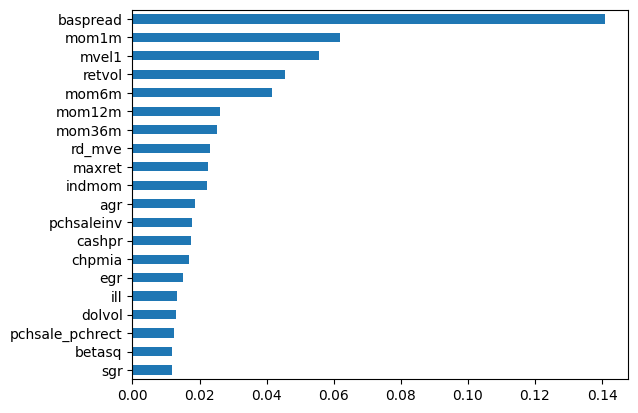

In [15]:
feat_importances = pd.Series(rf_fit.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).sort_values().plot(kind='barh')

Now, we can implement a expanding estimation of the RF model. This model takes a long time to estimate so I saved the predicted values, matched with realized returns, as a separate file.

Explain the expanding estimation procedure below: how does the train, validate, and test periods evolve?

In [39]:
merged_all['Year'] = pd.DatetimeIndex(merged_all['DATE']).year
min_train_years = 10
min_depth = 3
max_depth = 10
rf_pred = pd.DataFrame()

for y in range(merged_all['Year'].min()+min_train_years,merged_all['Year'].max()):
    print(y)
    X_train = merged_all[merged_all['Year']<y].iloc[:,2:96]
    X_train = pd.merge(X_train,sic_dummies,left_index=True,right_index=True,how='left')
    X_valid = merged_all[merged_all['Year']==y].iloc[:,2:96]
    X_valid = pd.merge(X_valid,sic_dummies,left_index=True,right_index=True,how='left')
    X_test = merged_all[merged_all['Year']==y+1].iloc[:,2:96]
    X_test = pd.merge(X_test,sic_dummies,left_index=True,right_index=True,how='left')
    Y_train = merged_all[merged_all['Year']<y]['RET'] - merged_all[merged_all['Year']<y]['Mkt']
    Y_valid = merged_all[merged_all['Year']==y]['RET'] - merged_all[merged_all['Year']==y]['Mkt']
    mse = []
    for d in range(min_depth,max_depth):
        temp_model = RandomForestRegressor(max_depth = d, n_jobs=-1, max_features='sqrt', random_state=1)
        rf_fit = temp_model.fit(X=X_train,y=Y_train)
        m = ((Y_valid-rf_fit.predict(X_valid))**2).mean()
        mse.append(m)
    d = mse.index(min(mse))+min_depth
    temp_model = RandomForestRegressor(max_depth = d, n_jobs=-1, max_features='sqrt', random_state=1)
    X_train = merged_all[merged_all['Year']<=y].iloc[:,2:96]
    X_train = pd.merge(X_train,sic_dummies,left_index=True,right_index=True,how='left')
    Y_train = merged_all[merged_all['Year']<=y]['RET'] - merged_all[merged_all['Year']<=y]['Mkt']
    rf_fit = temp_model.fit(X=X_train,y=Y_train)
    rf_pred = pd.concat([rf_pred, pd.DataFrame({'Pred':rf_fit.predict(X_test)}, index=X_test.index)])

2007
2008
2009
2010
2011
2012
2013
2014
2015


Let's match the RF predictions with actuals and save the file.


In [40]:
Y_test_RF = pd.merge(merged_all['RET'], rf_pred, left_index=True, right_index=True,how='right')
Y_test_RF = pd.merge(Y_test_RF, merged_all['DATE'], left_index=True, right_index=True, how='left')
Y_test_RF['Pred_q'] = Y_test_RF.groupby('DATE')['Pred'].transform(lambda x: pd.qcut(x.rank(method='first'), 5, labels=False))
Y_test_RF.to_excel(wd+'rf_pred_actual.xlsx')

If you did not run the code above, you can load the resulting file here:

In [42]:
Y_test_RF = pd.read_excel(wd+'rf_pred_actual.xlsx')

In [43]:
pd.pivot_table(Y_test_RF, values='RET',index='Pred_q',aggfunc=np.mean, fill_value=0)

/tmp/ipython-input-3523128014.py:1: FutureWarning: The provided callable <function mean at 0x7e2b99130220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.pivot_table(Y_test_RF, values='RET',index='Pred_q',aggfunc=np.mean, fill_value=0)


RET
Pred_q          
0       0.001801
1       0.005135
2       0.006012
3       0.007813
4       0.015489

Following the steps before, let's create a strategy return file and this time merge in the market returns as a benchmark.

1.1954465808653125


<Axes: xlabel='DATE'>

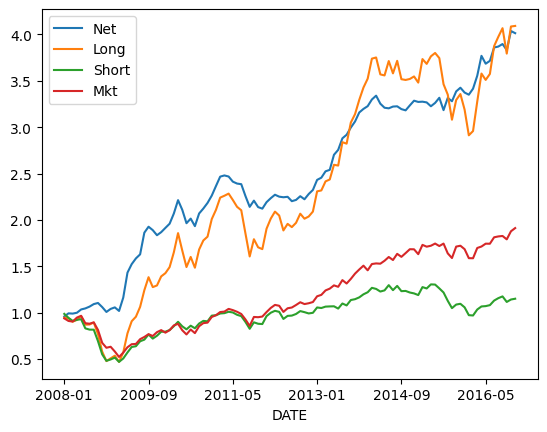

In [44]:
RF_ls = pd.DataFrame({'Long':Y_test_RF[Y_test_RF['Pred_q']==4].groupby('DATE')['RET'].mean(),'Short':Y_test_RF[Y_test_RF['Pred_q']==0].groupby('DATE')['RET'].mean()})
RF_ls['Net'] = RF_ls['Long']-RF_ls['Short']
Mkt = pd.DataFrame({'Mkt':merged_all.groupby('DATE')['Mkt'].median()})
RF_ls = RF_ls.merge(Mkt,left_index=True,right_index=True,how='left')
print((RF_ls['Net'].mean()*(12**.5))/RF_ls['Net'].std())
RF_ls[['Net','Long','Short','Mkt']].add(1).cumprod().plot()

# XGBoost

In [25]:
import xgboost as xgb
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## re-load and re-construct the dataset

In [26]:
merged_all = pd.read_pickle(wd+'Characteristics_Returns')

merged_all['Mkt'] = merged_all['Mkt-RF']+merged_all['RF']

merged_all['RET'] =  pd.to_numeric(merged_all['RET'],errors='coerce')
merged_all = merged_all.replace([np.inf, -np.inf], np.nan)
merged_all = merged_all.dropna(subset=['RET'])

cols = merged_all.columns[2:96]
for c in cols:
    merged_all[c] = merged_all[c].fillna(merged_all.groupby('DATE')[c].transform('mean'))

sic_dummies = pd.get_dummies(merged_all['sic2'],prefix='sic')

X_train = merged_all[merged_all['DATE']<'2007-01'].iloc[:,2:96]
X_train = pd.merge(X_train,sic_dummies,left_index=True,right_index=True,how='left')
X_test = merged_all[merged_all['DATE']>='2007-01'].iloc[:,2:96]
X_test = pd.merge(X_test,sic_dummies,left_index=True,right_index=True,how='left')
Y_train = merged_all[merged_all['DATE']<'2007-01']['RET'] - merged_all[merged_all['DATE']<'2007-01']['Mkt']
Y_test = merged_all[merged_all['DATE']>='2007-01']['RET'] - merged_all[merged_all['DATE']>='2007-01']['Mkt']

## An illustrative example: how the trees look like and their comparison with decision trees

In [27]:
X_example = merged_all[merged_all['DATE']<'2005-01'][['idiovol', 'mom1m', 'bm', 'invest', 'baspread', 'mvel1']]
Y_example = merged_all[merged_all['DATE']<'2005-01']['RET'] - merged_all[merged_all['DATE']<'2005-01']['Mkt']

In [28]:
depth = 3
num_round = 10
dexample = xgb.DMatrix(data=X_example,label=Y_example)

params = {
    'max_depth': depth,  # maximum depth of a tree
    'objective': 'reg:squarederror',
    # 'device': device,
    'learning_rate': 1,  # Set learning rate to 1 to emphasize the single tree
    'n_estimators': 1,
    'missing': None,
    'tree_method': 'exact',
    'grow_policy': 'depthwise',
    'base_score': 0.5,
    'min_child_weight': 0,
    'colsample_bytree': 1,
    # 'colsample_bylevel': 1,
    # 'colsample_bynode': 1,
    'reg_alpha': 0,
    'reg_lambda': 0,
}
evals = [(dexample, 'train')]
results = {}
xgb_fit = xgb.train(
    params = params,
    dtrain = dexample,
    num_boost_round = num_round,
    evals=evals,
    evals_result=results,
    verbose_eval=False
)

# Print the evaluation results
for i in range(len(results['train']['rmse'])):
    print(f"Round {i+1}: Train RMSE = {results['train']['rmse'][i]}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:19:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Round 1: Train RMSE = 0.2051067842508233
Round 2: Train RMSE = 0.2047834222903078
Round 3: Train RMSE = 0.20462621284449173
Round 4: Train RMSE = 0.20446662366052723
Round 5: Train RMSE = 0.20435752314263939
Round 6: Train RMSE = 0.2042287385211968
Round 7: Train RMSE = 0.20401828540762498
Round 8: Train RMSE = 0.20394426539220584
Round 9: Train RMSE = 0.20370716871406466
Round 10: Train RMSE = 0.2036353501328006


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


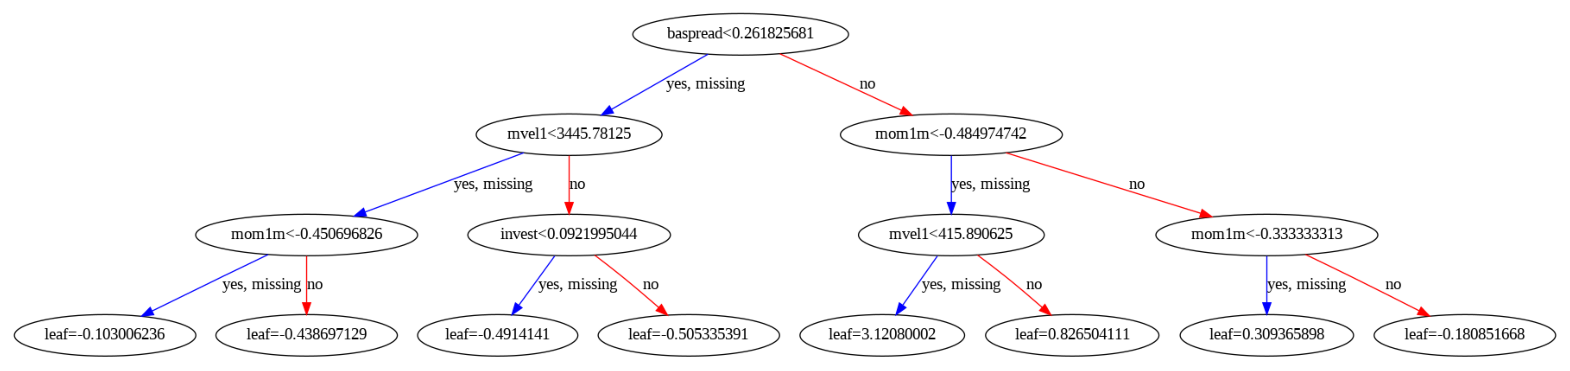

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
xgb.plot_tree(xgb_fit, num_trees=0, ax=ax)
plt.show()

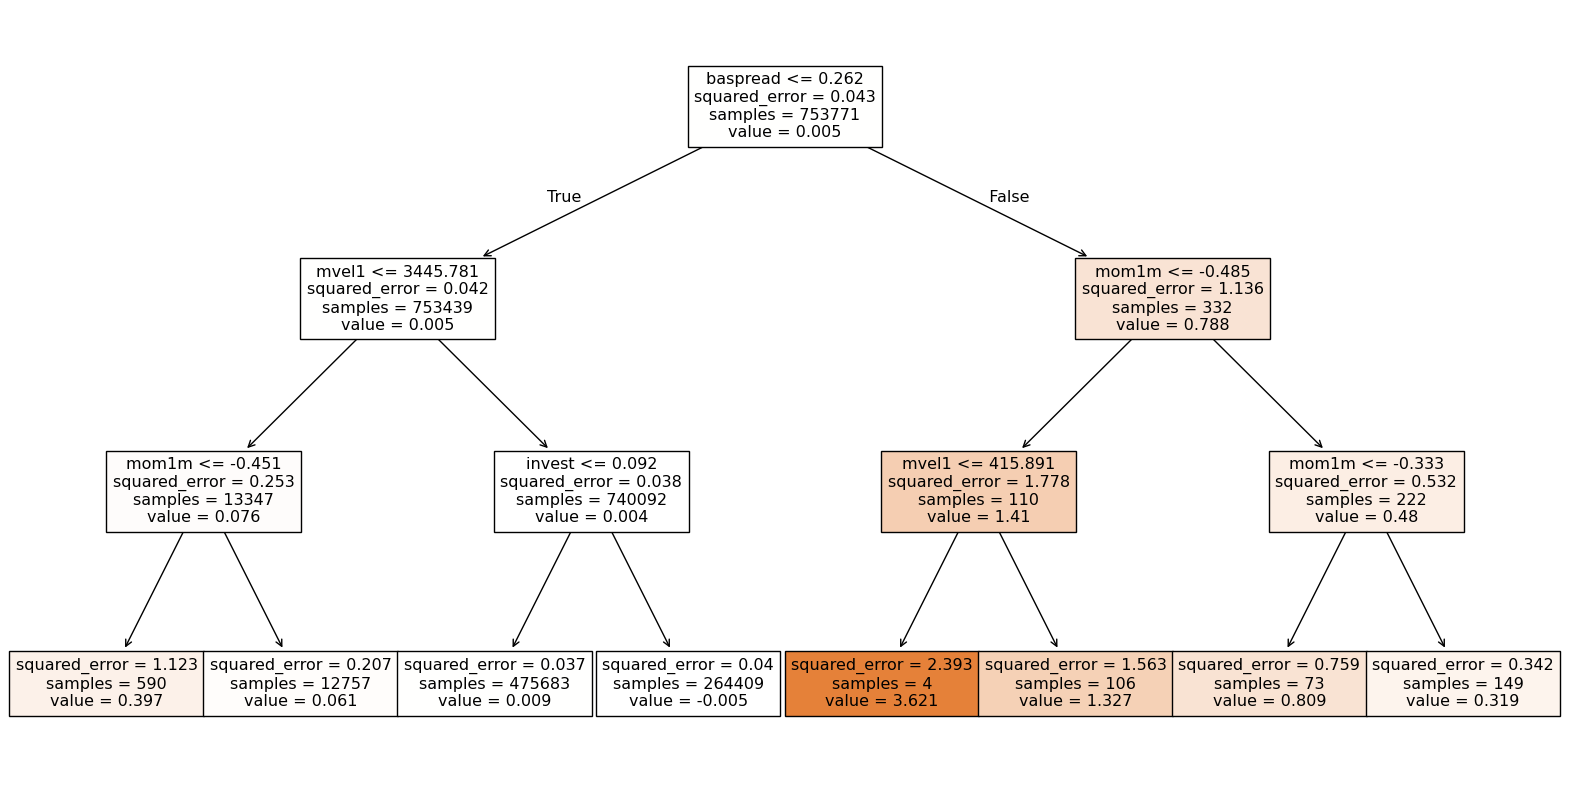

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
reg = DecisionTreeRegressor(max_depth=3)
reg.fit(X_example, Y_example)
plt.figure(figsize=(20,10))
tree.plot_tree(reg, filled=True, feature_names=X_example.columns)
plt.show()

In [31]:
# decision tree training loss
from sklearn.metrics import mean_squared_error
y_pred = reg.predict(X_example)

training_mse = mean_squared_error(Y_example, y_pred)
training_rmse = np.sqrt(training_mse)
print(f"Training Loss (RMSE): {training_rmse}")

Training Loss (RMSE): 0.20510678488493272


## Now repeat the analysis we did using random forest - training sample and out-of-sample

In [32]:
depth = 5
num_round = 100
dtrain = xgb.DMatrix(data=X_train,label=Y_train)
dtest = xgb.DMatrix(X_test)

params = {
    'max_depth': depth,  # maximum depth of a tree
    'objective': 'reg:squarederror',
    'device': device
}
xgb_fit = xgb.train(
    params = params,
    dtrain = dtrain,
    num_boost_round = num_round,
)

xgb_pre_OOS = pd.DataFrame({'Pred':xgb_fit.predict(dtest)},index=Y_test.index)
Y_test_xgb = pd.merge(pd.DataFrame({'Ret':Y_test}), xgb_pre_OOS, left_index=True, right_index=True,how='left')
Y_test_xgb = pd.merge(Y_test_xgb, merged_all['DATE'], left_index=True, right_index=True, how='left')

# notice that because of the sparcity of the model or the missing characteristics, many obs have the same prediction, thus we need to rank them first
Y_test_xgb['Pred_q'] = Y_test_xgb.groupby('DATE')['Pred'].transform(lambda x: pd.qcut(x.rank(method='first'), 5, labels=False))
pd.pivot_table(Y_test_xgb, values='Ret',index='Pred_q',aggfunc=np.mean, fill_value=0)
xgb_ls = pd.DataFrame({'Long':Y_test_xgb[Y_test_xgb['Pred_q']==4].groupby('DATE')['Ret'].mean(),'Short':Y_test_xgb[Y_test_xgb['Pred_q']==0].groupby('DATE')['Ret'].mean()})
xgb_ls['Net'] = xgb_ls['Long']-xgb_ls['Short']
print((xgb_ls['Net'].mean()*(12**.5))/xgb_ls['Net'].std())

1.823009233701494


/tmp/ipython-input-2841551277.py:23: FutureWarning: The provided callable <function mean at 0x7e2b99130220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.pivot_table(Y_test_xgb, values='Ret',index='Pred_q',aggfunc=np.mean, fill_value=0)


In [33]:
merged_all['Year'] = pd.DatetimeIndex(merged_all['DATE']).year
min_train_years = 10
min_depth = 3
max_depth = 10
xgb_pred = pd.DataFrame()


for y in range(merged_all['Year'].min()+min_train_years,merged_all['Year'].max()):
    print(y)
    X_train = merged_all[merged_all['Year']<y].iloc[:,2:96]
    X_train = pd.merge(X_train,sic_dummies,left_index=True,right_index=True,how='left')
    X_valid = merged_all[merged_all['Year']==y].iloc[:,2:96]
    X_valid = pd.merge(X_valid,sic_dummies,left_index=True,right_index=True,how='left')
    X_test = merged_all[merged_all['Year']==y+1].iloc[:,2:96]
    X_test = pd.merge(X_test,sic_dummies,left_index=True,right_index=True,how='left')
    Y_train = merged_all[merged_all['Year']<y]['RET'] - merged_all[merged_all['Year']<y]['Mkt']
    Y_valid = merged_all[merged_all['Year']==y]['RET'] - merged_all[merged_all['Year']==y]['Mkt']
    mse = []
    dtrain = xgb.DMatrix(data=X_train,label=Y_train)
    dvalid = xgb.DMatrix(X_valid)
    dtest = xgb.DMatrix(X_test)
    for d in range(min_depth,max_depth):
        params = {
            'max_depth': d,
            'objective': 'reg:squarederror',
            'device': device,
            'seed': 42
        }
        xgb_fit = xgb.train(
            params = params,
            dtrain = dtrain,
            num_boost_round = num_round,
        )
        m = ((Y_valid-xgb_fit.predict(dvalid))**2).mean()
        mse.append(m)
    d = mse.index(min(mse))+min_depth
    params = {
        'max_depth': d,
        'objective': 'reg:squarederror',
        'device': device,
        'seed': 42
        }
    # print(y, d)
    X_train = merged_all[merged_all['Year']<=y].iloc[:,2:96]
    X_train = pd.merge(X_train,sic_dummies,left_index=True,right_index=True,how='left')
    Y_train = merged_all[merged_all['Year']<=y]['RET'] - merged_all[merged_all['Year']<=y]['Mkt']
    dtrain = xgb.DMatrix(data=X_train,label=Y_train)
    xgb_fit = xgb.train(
        params = params,
        dtrain = dtrain,
        num_boost_round = num_round,
    )
    xgb_pred = pd.concat([xgb_pred, pd.DataFrame({'Pred':xgb_fit.predict(dtest)}, index=X_test.index)])

2007
2008
2009
2010
2011
2012
2013
2014
2015


In [34]:
Y_test_xgb = pd.merge(merged_all['RET'], xgb_pred, left_index=True, right_index=True,how='right')
Y_test_xgb = pd.merge(Y_test_xgb, merged_all['DATE'], left_index=True, right_index=True, how='left')
Y_test_xgb['Pred_q'] = Y_test_xgb.groupby('DATE')['Pred'].transform(lambda x: pd.qcut(x.rank(method='first'), 5, labels=False))
Y_test_xgb.to_excel(wd+'xgb_pred_actual.xlsx')

In [36]:
Y_test_xgb = pd.read_excel(wd+'xgb_pred_actual.xlsx')

In [37]:
pd.pivot_table(Y_test_xgb, values='RET',index='Pred_q',aggfunc=np.mean, fill_value=0)

/tmp/ipython-input-3257502084.py:1: FutureWarning: The provided callable <function mean at 0x7e2b99130220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.pivot_table(Y_test_xgb, values='RET',index='Pred_q',aggfunc=np.mean, fill_value=0)


RET
Pred_q          
0      -0.001337
1       0.005036
2       0.007640
3       0.009099
4       0.015814

2.044768292104791


<Axes: xlabel='DATE'>

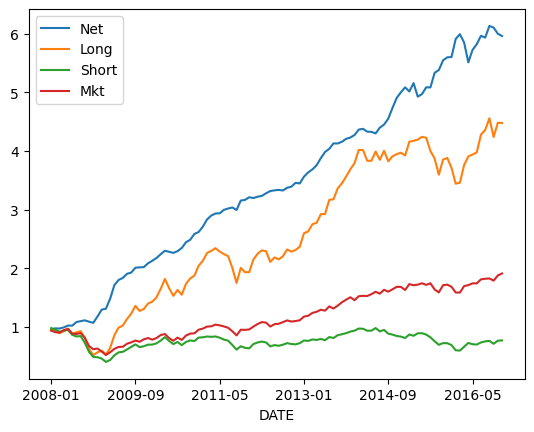

In [38]:
xgb_ls = pd.DataFrame({'Long':Y_test_xgb[Y_test_xgb['Pred_q']==4].groupby('DATE')['RET'].mean(),'Short':Y_test_xgb[Y_test_xgb['Pred_q']==0].groupby('DATE')['RET'].mean()})
xgb_ls['Net'] = xgb_ls['Long']-xgb_ls['Short']
Mkt = pd.DataFrame({'Mkt':merged_all.groupby('DATE')['Mkt'].median()})
xgb_ls = xgb_ls.merge(Mkt,left_index=True,right_index=True,how='left')
print((xgb_ls['Net'].mean()*(12**.5))/xgb_ls['Net'].std())
xgb_ls[['Net','Long','Short','Mkt']].add(1).cumprod().plot()